# Pipeline labelisation

## Imports des packages

In [1]:
import sys
sys.path.append('../src')
import shutil
import yaml
import py7zr
import os
import s3fs
from satellite_image import SatelliteImage
from labeler import RILLabeler
from labeler import BDTOPOLabeler
from labeled_satellite_image import SegmentationLabeledSatelliteImage
from utils import *
from filter import *
import matplotlib.pyplot as plt
import numpy as np
import rasterio.plot as rp
import re
from datetime import datetime
from tqdm import tqdm

In [40]:
update_storage_access()

Sentinel=False

## Téléchargement des données Pléiades

In [41]:
environment = get_environment()

bucket = environment["bucket"]
if Sentinel:
    path_s3_sentinel2_data = environment["sources"]["SENTINEL2"]["MAYOTTE"][2021]
    path_local_sentinel2_data = environment["local-path"]["SENTINEL2"]
else:
    path_s3_pleiades_data = environment["sources"]["PLEIADES"]
    path_local_pleiades_data = environment["local-path"]["PLEIADES"]

path_s3_bdtopo_data = environment["sources"]["BDTOPO"][2022]["guyane"]
path_local_bdtopo_data = environment["local-path"]["BDTOPO"][2022]["guyane"]

fs = s3fs.S3FileSystem(client_kwargs={"endpoint_url": "https://minio.lab.sspcloud.fr"})

On télécharge les fichiers depuis s3 (à mettre dans le setup.sh?)

In [42]:
if Sentinel:
        fs.download(
        rpath=f"{bucket}/{path_s3_sentinel2_data}",
        lpath=f"../{path_local_sentinel2_data}",
        recursive=True)
else:
        fs.download(
                rpath=f"{bucket}/{path_s3_pleiades_data}",
                lpath=f"../{path_local_pleiades_data}",
                recursive=True)

In [5]:
fs.download(
        rpath=f"{bucket}/{path_s3_bdtopo_data}",
        lpath=f"../{path_local_bdtopo_data}",
        recursive=True)

## Découpage et filtrage des images

In [43]:
if Sentinel:
    images_paths = [f"../{path_local_sentinel2_data}/" + p for p in os.listdir(f"../{path_local_sentinel2_data}/")]
else:
    images_paths = [f"../{path_local_pleiades_data}/16bits/ORT_2022072050325085_U22N/" + p for p in os.listdir(f"../{path_local_pleiades_data}/16bits/ORT_2022072050325085_U22N/")]

In [44]:
if Sentinel:
    date = datetime(2021, 9, 1)
else:
    date = datetime.strptime(re.search(r'ORT_(\d{8})', images_paths[0]).group(1), '%Y%m%d')

On importes les `SatelliteImage` dans une liste.

In [46]:
if Sentinel:
    list_images = [
     SatelliteImage.from_raster(
        filename,
        dep = "976",
        date = date, 
        n_bands = 12
    ) for filename in tqdm(images_paths)]
else:
    list_images = [
     SatelliteImage.from_raster(
        filename,
        dep = "973",
        date = date, 
        n_bands = 4,
    ) for filename in tqdm(images_paths)]

100%|██████████| 240/240 [00:33<00:00,  7.21it/s]


On découpe les images initialement de dimension 2000 en plusieurs image de dimension `dim`. On ne garde ensuite que les images qui sont pertinentes à l'aide de la méthode `filter_images`. Une image contenant moins de 50% de pixels non noirs n'est pas retenue.

In [47]:
dim = 250

In [48]:
splitted_list_images = [im for sublist in tqdm(list_images) for im in sublist.split(250) if not is_too_black(im)]

100%|██████████| 240/240 [00:00<00:00, 2448.59it/s]


In [49]:
len(splitted_list_images)

15360

On peut représenter graphiquement nos images grâce à la méthode `plot` :

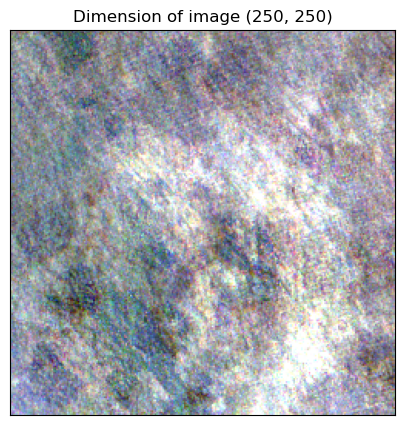

In [12]:
if Sentinel:
    splitted_list_images[293].plot([3,2,1]) # RGB
else:
    splitted_list_images[2793].plot([0,1,2]) # RGB

On peut représenter l'image infrarouge : 

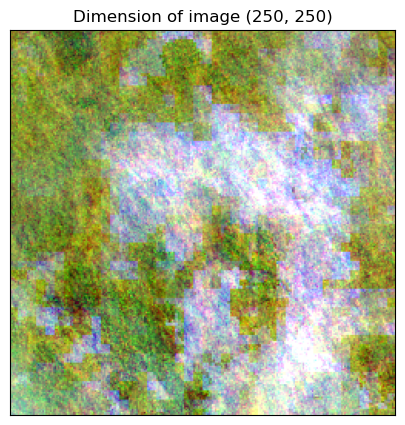

In [13]:
if Sentinel:
    splitted_list_images[293].plot([3, 1, 0]) # RGB (Infrarouge, rouge, vert)
else:
    splitted_list_images[2793].plot([3, 0, 1]) # RGB (Infrarouge, rouge, vert)

Ou bien qu'une seule bande :

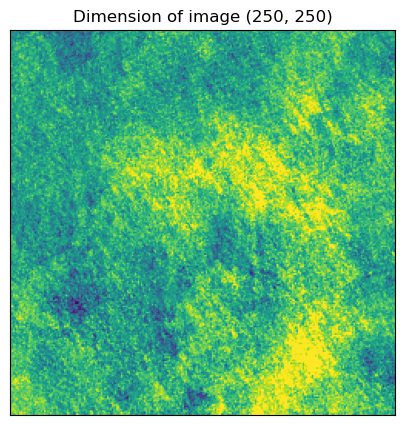

In [14]:
if Sentinel:
    splitted_list_images[293].plot([1]) # Une bande
else:
    splitted_list_images[2793].plot([1]) # Une bande

## Labélisation avec le RIL

On définit un `labeler` incluant la taille des buffers que l'on souhaite ainsi que la forme de ceux-ci.

In [50]:
if Sentinel:
    labeler_RIL = RILLabeler(date, dep="976", buffer_size=6, cap_style=3)
else:
    labeler_RIL = RILLabeler(date, dep="973", buffer_size=6, cap_style=3)

A l'aide de notre `labeler` on créer une `SegmentationLabeledSatelliteImage`.

In [51]:
list_labeled_images = [
     SegmentationLabeledSatelliteImage(
        sat_im,
        labeler_RIL.create_segmentation_label(sat_im),
        "RIL",
        date
     ) for sat_im in tqdm(splitted_list_images)]

100%|██████████| 15360/15360 [04:10<00:00, 61.25it/s]


Il est également possible de représenter graphiquement l'image ainsi que son label grâce à la méthode `plot()`. Ici un exemple d'image ou l'on constate la présence d'immeubles : 

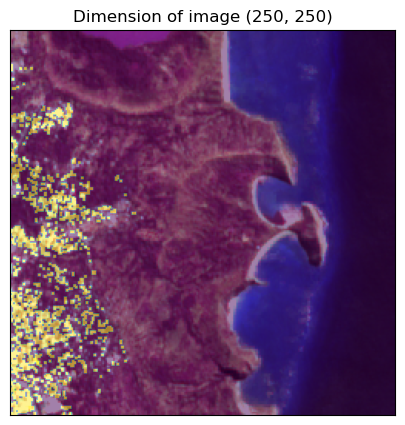

In [17]:
if Sentinel:
    list_labeled_images[40].plot([4,3,2],0.5)
else:
    list_labeled_images[2793].plot([0,1,2],0)

Et voici un exemple sans immeuble : 

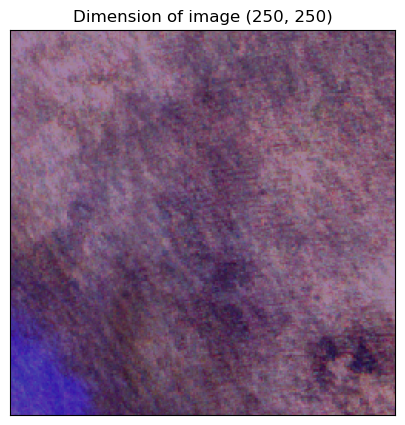

In [18]:
if Sentinel:
    list_labeled_images[0].plot([4,3,2],0.5)
else:
    list_labeled_images[0].plot([0,1,2],0.5)

## Filtrer les données labelisées grâce au RIL

In [19]:
from filter import RILFilter

In [52]:
if Sentinel:
    ril_filter = RILFilter("976", 100000, 0.6)
else:
    ril_filter = RILFilter("973", 100000, 0.6)

In [53]:
filtered_list = [labeled_image for labeled_image in tqdm(list_labeled_images) if ril_filter.validate(labeled_image)]

/home/onyxia/work/detection-bidonvilles/notebooks/../src/filter.py:163: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  intersection_area = float(gr_geometry.intersection(geom).area)
/home/onyxia/work/detection-bidonvilles/notebooks/../src/filter.py:163: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  intersection_area = float(gr_geometry.intersection(geom).area)
/home/onyxia/work/detection-bidonvilles/notebooks/../src/filter.py:163: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  intersection_area = float(gr_geometry.intersection(geom).area)
/home/onyxia/work/detection-bidonvilles/notebooks/../src/filter.py:163: FutureWarning: Calling float on a single element Series is deprecated and will raise a T

In [54]:
len(filtered_list)

1448

On veut repérer les images avec des bâtiments

In [55]:
building_pixel_counts = [(labeled_image.label.sum() > 0) for labeled_image in filtered_list]

In [56]:
sum(building_pixel_counts)

502

480 images sur 1268 avec des labels.

In [57]:
sum([(labeled_image.label.sum() > 0) for labeled_image in list_labeled_images])

3465

In [58]:
len(list_labeled_images)

15360

vs. 3350 images sur 13250 en tout avec des buildings

In [54]:
480 / 1268

0.3785488958990536

In [55]:
(3351 - 480)/(13254 - 1268)

0.23952945102619724

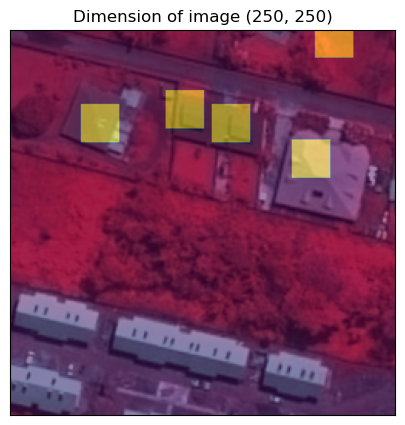

In [59]:
if Sentinel:
    [labeled_image for labeled_image, building_dummy in zip(filtered_list, building_pixel_counts) if building_dummy][3].plot([3,2,1])
else:
    [labeled_image for labeled_image, building_dummy in zip(filtered_list, building_pixel_counts) if building_dummy][15].plot([0,1,2])

## Labélisation avec la BDTOPO

On peut réaliser la labelisation grâce à la BDTOPO plutôt que le RIL afin d'avoir des contours plus précis.

In [ ]:
labeler_BDTOPO = BDTOPOLabeler(date)

In [ ]:
list_labeled_images = [
     SegmentationLabeledSatelliteImage(
        sat_im,
        labeler_BDTOPO.create_segmentation_label(sat_im),
        "BDTOPO",
        date
     ) for sat_im in tqdm(splitted_list_images)]

In [ ]:
list_labeled_images[2796].plot([0,1,2])

In [ ]:
list_labeled_images[0].plot([0,1,2])